In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.inspection import permutation_importance
import lightgbm as lgb

from utils.functions import calculate_mean_performance_sector, prepare_train_test_data, return_learning_curve, create_results_df, equitative_return, acumulative_year_earnings

In [74]:
df_final = pd.read_feather("./data/final_data.feather")

### Creation of the Baseline
The baseline is created to have a reference to compare the performance of the model. The baseline is created by using the n_aseets(the baseline will use the same n assets that us), that performed the best in the last year. The baseline will be the average of the returns of the n_assets.

In [75]:
df_final['1year_price_variation'] = (df_final['1year_price'] - df_final['price']) / df_final['price']
df_final['Baseline'] = df_final.groupby('asset_num')['1year_price_variation'].shift(4)

In [76]:
def calculate_sp500_return() -> float:
    sp500 = pd.read_csv("./data/initial_data/SP500_TR.csv")
    sp500['date'] = pd.to_datetime(sp500['date']).dt.to_period('Q')
    sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)
    sp500['1year_sp500_return'] = (sp500['SP500'].shift(-4) - sp500['SP500']) / sp500['SP500']
    sp500 = sp500[sp500['date'] < '2023Q4']
    return sp500[['date', '1year_sp500_return']]

sp500 = calculate_sp500_return()
sp500.head()

C:\Users\ALEX\AppData\Local\Temp\ipykernel_5360\2621213675.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)


,date,1year_sp500_return
0,2005Q1,0.057696
1,2005Q2,0.127167
2,2005Q3,0.091986
3,2005Q4,0.106072
4,2006Q1,0.157942


In [77]:
df_final = df_final.merge(sp500, left_on='quarter', right_on='date', how='left').drop(columns='date')
df_final['asset_return_diff_sp500'] = df_final['1year_price_variation'] - df_final['1year_sp500_return']
df_final['asset_return_gt_sp500'] = df_final['asset_return_diff_sp500'] > 0

### Creation of more features
Creating new features related to the EV or other features and deleting original ones, p.e.: ebit, ebitda, net income, revenue.
That's because we though fundamental features without any transformation couldn't be comparable between companies of different sizes.

In [78]:
df_final['EV_EBITDA'] = df_final['ev'] / df_final['ebitda']
df_final['EV_EBIT'] = df_final['ev'] / df_final['ebit']
df_final['P_B_ratio'] = df_final['price'] / (df_final['T_assets'] - df_final['T_debt'])

df_final['Debt_to_Equity'] = df_final['T_debt'] / (df_final['T_assets'] - df_final['T_debt'])
df_final['Net_Debt_to_EBITDA'] = df_final['net_debt'] / df_final['ebitda']

df_final['Asset_Turnover'] = df_final['T_rev'] / df_final['T_assets']
df_final['Cash_Conversion_Ratio'] = df_final['cash'] / df_final['T_rev']

We also decided to create new features related to the sector of each company, with that we can see the performance of the company in relation to the sector.

In [79]:
sector_performance_cols = ['EV_EBITDA', 'EV_EBIT', 'P_B_ratio', 'Debt_to_Equity', 'Net_Debt_to_EBITDA', 'Asset_Turnover', 'Cash_Conversion_Ratio']

In [80]:
df_final = calculate_mean_performance_sector(df_final, sector_performance_cols)

In [81]:
df_final.columns

Index(['quarter', 'asset_num', 'price', 'cap_ex', 'cash', 'dil_shares', 'ebit',
       'ebitda', 'net_inc', 'survivor', 'T_assets', 'T_debt', 'T_rev',
       'sector', '1year_price', 'new_sector', 'ebit_marg', 'ebitda_marg',
       'net_marg', 'ROA', 'ROE', 'debts_assets', 'net_debt', 'cash_ratio',
       'net_income_per_share', 'price_earning_ratio', 'ev',
       '1year_price_variation', 'Baseline', '1year_sp500_return',
       'asset_return_diff_sp500', 'asset_return_gt_sp500', 'EV_EBITDA',
       'EV_EBIT', 'P_B_ratio', 'Debt_to_Equity', 'Net_Debt_to_EBITDA',
       'Asset_Turnover', 'Cash_Conversion_Ratio', 'EV_EBITDA_mean_sector_diff',
       'EV_EBIT_mean_sector_diff', 'P_B_ratio_mean_sector_diff',
       'Debt_to_Equity_mean_sector_diff',
       'Net_Debt_to_EBITDA_mean_sector_diff',
       'Asset_Turnover_mean_sector_diff',
       'Cash_Conversion_Ratio_mean_sector_diff'],
      dtype='object')

In [82]:
basic_features = ['cap_ex', 'cash', 'ebit', 'ebitda', 'net_inc', 'T_assets', 'T_debt', 'T_rev','dil_shares','net_debt','ev']
df_final = df_final.drop(columns=basic_features, errors='ignore')

# Handle missing or infinite values
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [83]:
info_cols = ['asset_num','quarter','sector','survivor','prices_avg','1year_price','prices_std','1year_price_variation','1year_sp500_return','asset_return_diff_sp500']
target_col = 'asset_return_gt_sp500'
df_final['new_sector'] = df_final['new_sector'].astype('category')

feature_cols = [col for col in df_final.columns if col not in info_cols + [target_col]]
print(df_final[feature_cols].isna().sum())

price                                        0
new_sector                                   0
ebit_marg                                 2741
ebitda_marg                               2796
net_marg                                   387
ROA                                        405
ROE                                        405
debts_assets                               396
cash_ratio                                1673
net_income_per_share                       564
price_earning_ratio                        565
Baseline                                  3455
EV_EBITDA                                 3007
EV_EBIT                                   2954
P_B_ratio                                  396
Debt_to_Equity                             396
Net_Debt_to_EBITDA                        2846
Asset_Turnover                             405
Cash_Conversion_Ratio                      440
EV_EBITDA_mean_sector_diff                3007
EV_EBIT_mean_sector_diff                  2954
P_B_ratio_mea

### Creation of the dataset partitions to train the model

In [84]:
df_final['quarter'] = df_final['quarter'].astype('str')
df_final = df_final[~df_final['quarter'].isin(['2005Q1','2005Q2','2005Q3','2005Q4'])]

In [85]:
unique_quarters = df_final['quarter'].astype('str').unique()
unique_quarters

array(['2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
       '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
       '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
       '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
       '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
       '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
       '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
       '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
       '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2',
       '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4',
       '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2',
       '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3'], dtype=object)

In [86]:
window_size = 12
datasets = prepare_train_test_data(df_final, 'quarter', feature_cols, target_col, window_size=window_size)

### Searching for the best hyperparameters

In [87]:
# This code is commented to avoid running it by mistake but it is left here to show the results
# for n_estimators in [50, 100]:
#     for learning_rate in [0.01, 0.1]:
#         for num_leaves in [32, 64]:
#             for path_smooth in [0.1, 0.5]:
#                 params_lgb = {
#                     'metric': 'logloss',
#                     'random_state': 1,
#                     'verbose': 0,
#                     'n_estimators': n_estimators,
#                     'learning_rate': learning_rate,
#                     'num_leaves': num_leaves,
#                     'path_smooth': path_smooth
#                 }
                
#                 models_list = {}
#                 results_list = {}
#                 predictions_list = {}
#                 compute_importance = True
#                 permut_importances_list = {}
#                 categorical_features = ['new_sector']

#                 for i in range(len(datasets)):
#                     test_quarter = unique_quarters[i + window_size]
#                     #print(f"Training model to test quarter: {test_quarter}")

#                     X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]

#                     eval_result = {}

#                     model = lgb.LGBMClassifier(**params_lgb)

#                     model.fit(
#                         X_train, y_train,
#                         categorical_feature=categorical_features,
#                         eval_set=[(X_test, y_test), (X_train, y_train)],
#                         eval_metric='logloss',
#                         callbacks=[lgb.record_evaluation(eval_result=eval_result)]
#                     )
                    
#                     results_list[(test_quarter)] = eval_result


#                 test_lc = return_learning_curve(results_list,"valid_0")
#                 train_lc = return_learning_curve(results_list,"training")

#                 train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
#                 test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))



#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

#                 sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax1)
#                 ax1.hlines(0, 0, len(train_lc['n_trees'].unique()), color='red', linestyle='--')
#                 ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
#                 ax1.set_title('Training Learning Curve')

#                 sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax2)
#                 ax2.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
#                 ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)
#                 ax2.set_title('Test Learning Curve')

#                 plt.suptitle(f'Learning Curves with n_est={n_estimators},lr={learning_rate},n_leaves={num_leaves},path={path_smooth}', fontsize=16, y=1.02)

#                 plt.tight_layout()  
#                 plt.show()

After comparing the learning curves, we choose the model with Lr = 0.01, n_leaves = 64, path_smooth = 0.1 or 0.5, and n_estimators = 100.

In [88]:
params_lgb = {
    'objective': 'binary',
    'metric': 'logloss',
    'random_state': 1,
    'verbose': 0,
    'n_estimators': 100,
    'learning_rate': 0.01,
    'num_leaves': 64,
    'path_smooth': 0.5
}



models_list = {}
results_list = {}
predictions_list = {}
compute_importance = True
permut_importances_list = {}
categorical_features = ['new_sector']

for i in range(len(datasets)):
    test_quarter = unique_quarters[i + window_size]
    print(f"Training model to test quarter: {test_quarter}")
    
    X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]
    
    eval_result = {}
    
    model = lgb.LGBMClassifier(**params_lgb)
    
    model.fit(
        X_train, y_train,
        categorical_feature=categorical_features,
        eval_set=[(X_test, y_test), (X_train, y_train)],
        eval_metric='logloss',
        callbacks=[lgb.record_evaluation(eval_result=eval_result)]
    )
    
    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=0)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame({'importance': r.importances_mean, 'feature': feature_names})
    else:
        df_permutation_importance = pd.DataFrame()
    
    
    models_list[(test_quarter)] = model
    results_list[(test_quarter)] = eval_result
    predictions_list[(test_quarter)] = model.predict_proba(X_test)[:,1]
    permut_importances_list[(test_quarter)] = df_permutation_importance

Training model to test quarter: 2009Q1
Training model to test quarter: 2009Q2
Training model to test quarter: 2009Q3
Training model to test quarter: 2009Q4
Training model to test quarter: 2010Q1
Training model to test quarter: 2010Q2
Training model to test quarter: 2010Q3
Training model to test quarter: 2010Q4
Training model to test quarter: 2011Q1
Training model to test quarter: 2011Q2
Training model to test quarter: 2011Q3
Training model to test quarter: 2011Q4
Training model to test quarter: 2012Q1
Training model to test quarter: 2012Q2
Training model to test quarter: 2012Q3
Training model to test quarter: 2012Q4
Training model to test quarter: 2013Q1
Training model to test quarter: 2013Q2
Training model to test quarter: 2013Q3
Training model to test quarter: 2013Q4
Training model to test quarter: 2014Q1
Training model to test quarter: 2014Q2
Training model to test quarter: 2014Q3
Training model to test quarter: 2014Q4
Training model to test quarter: 2015Q1
Training model to test qu

In [89]:
test_lc = return_learning_curve(results_list,"valid_0")
train_lc = return_learning_curve(results_list,"training")

train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

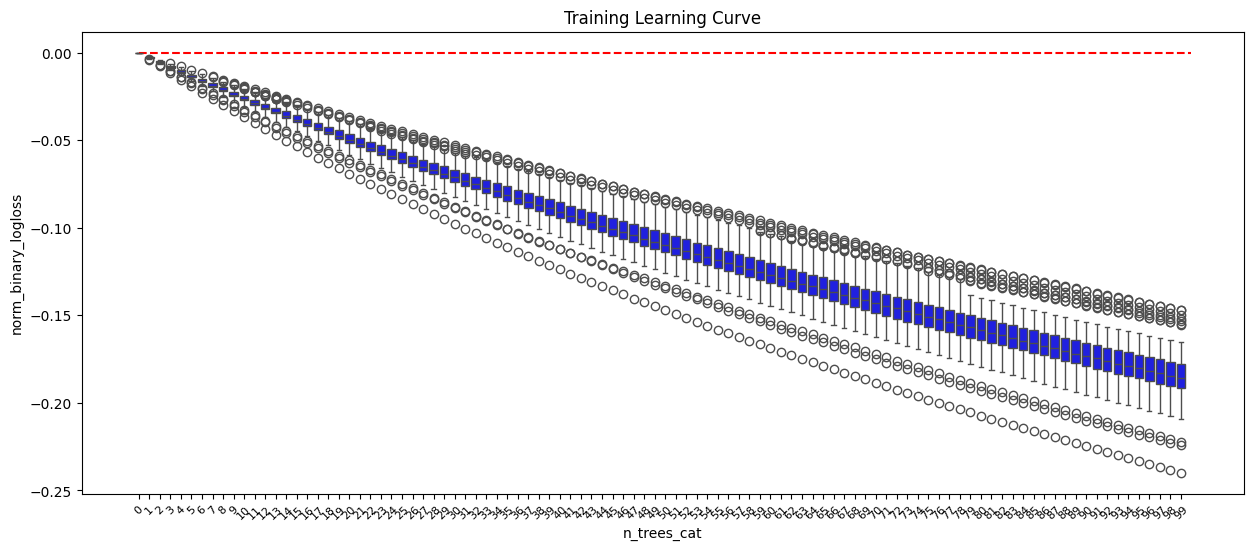

In [90]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve')
plt.show()

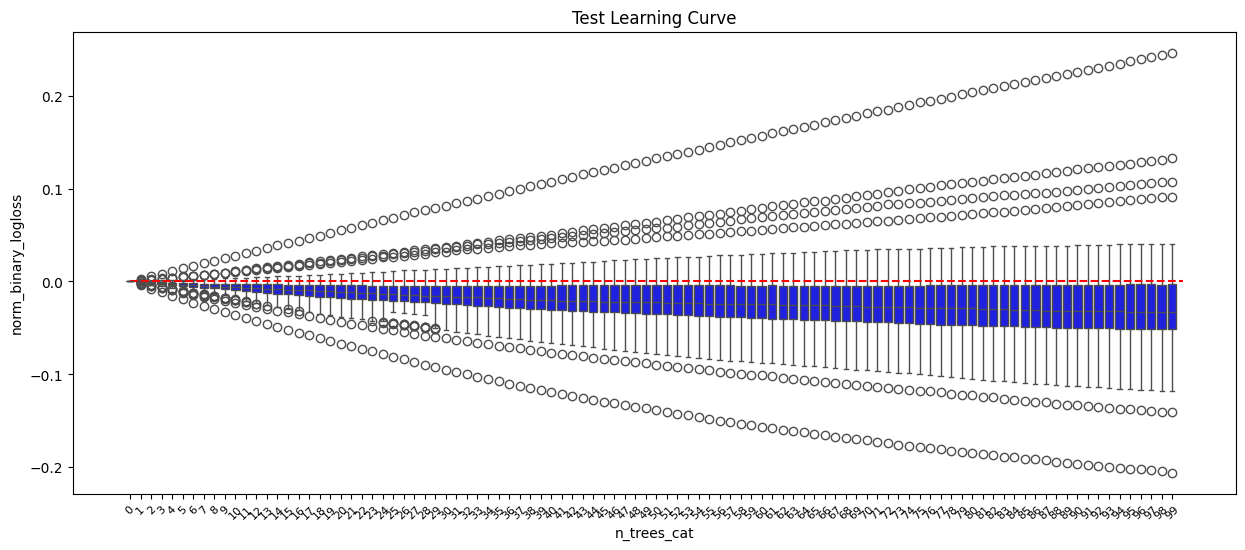

In [91]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Test Learning Curve')
plt.show()

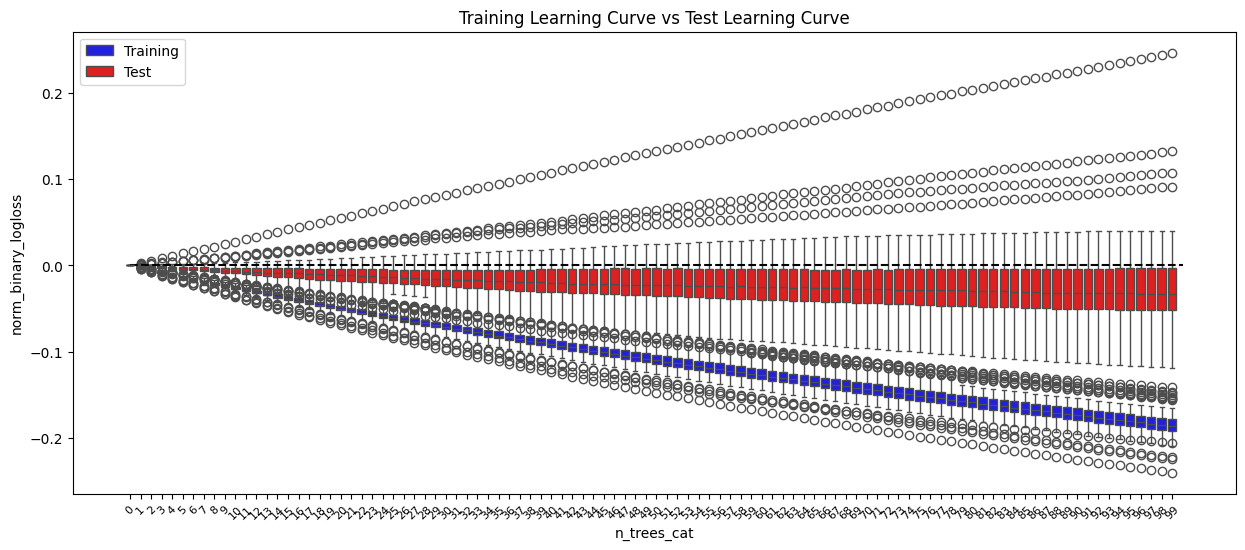

In [92]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', label='Training')
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='red', label='Test')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='black', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve vs Test Learning Curve')
plt.legend()
plt.show()

In [93]:
importance_dfs = []

# Generate a DataFrame for each quarter with the permutation importances
for quarter, df_imp in permut_importances_list.items():
    df_imp['quarter'] = quarter
    df_imp['importance'] = df_imp['importance']
    importance_dfs.append(df_imp)

df_importances = pd.concat(importance_dfs, ignore_index=True)

df_importances

,importance,feature,quarter
0,0.011876,price,2009Q1
1,-0.014305,new_sector,2009Q1
2,0.001350,ebit_marg,2009Q1
3,0.001889,ebitda_marg,2009Q1
4,-0.003239,net_marg,2009Q1
...,...,...,...
1529,-0.002823,P_B_ratio_mean_sector_diff,2023Q3
1530,0.004839,Debt_to_Equity_mean_sector_diff,2023Q3
1531,-0.000403,Net_Debt_to_EBITDA_mean_sector_diff,2023Q3
1532,0.000269,Asset_Turnover_mean_sector_diff,2023Q3


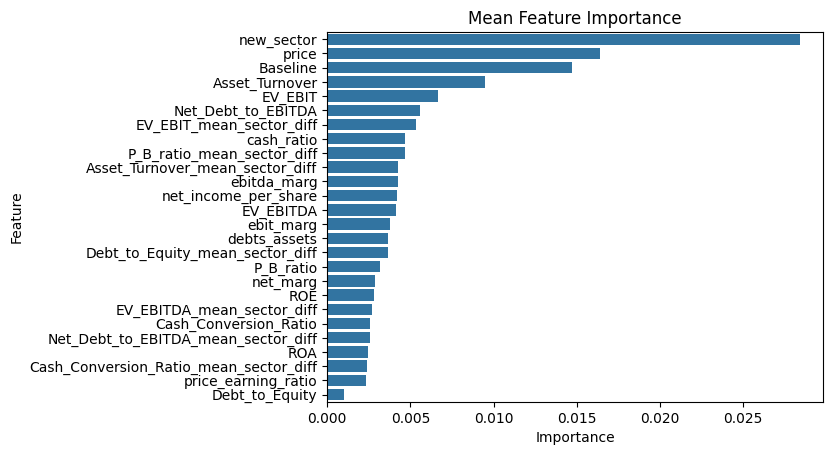

In [94]:
df_importances_mean = df_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
sns.barplot(x=df_importances_mean, y=df_importances_mean.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Mean Feature Importance')
plt.show()

In [95]:
df_importances_sorted = df_importances.sort_values(by=['quarter','importance'], ascending=[True,False]).reset_index(drop=True)
df_importances_sorted["rank"] = df_importances_sorted.groupby(["quarter"]).cumcount()
r_all_permutation_importances = df_importances_sorted[df_importances_sorted["rank"]<3]

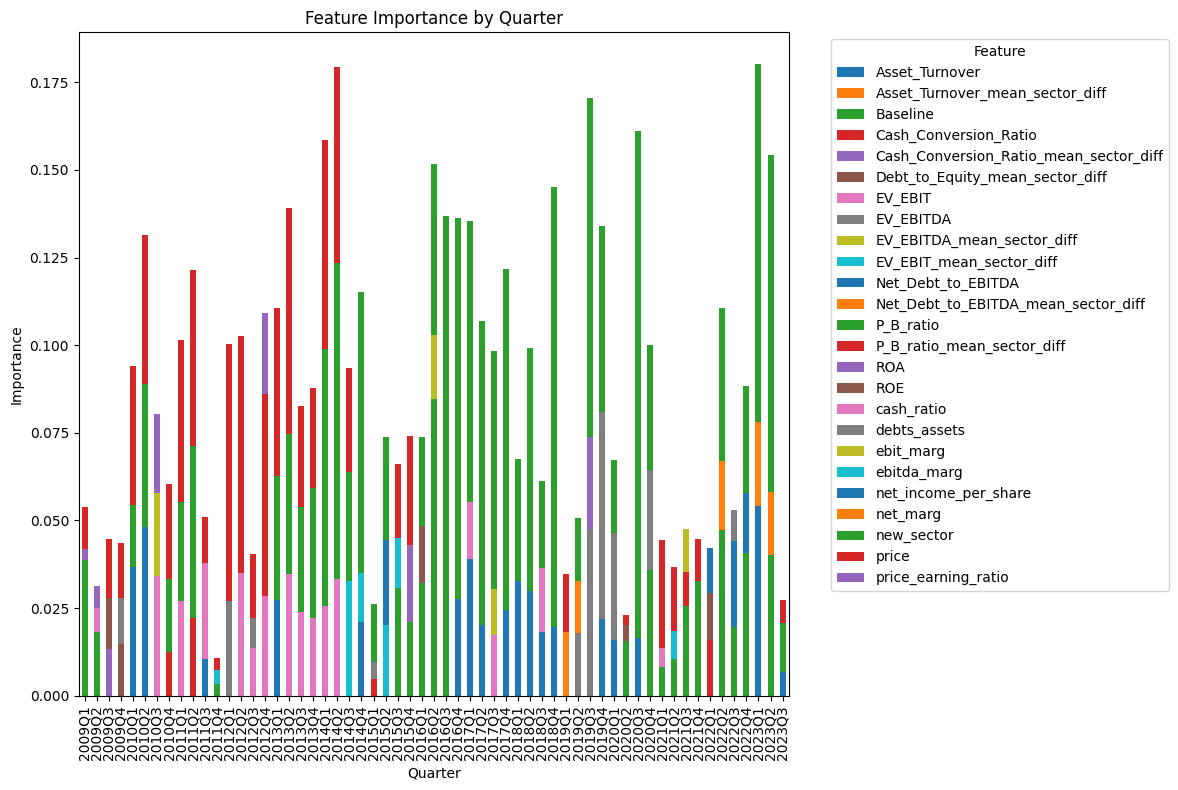

In [96]:
pivot_df = r_all_permutation_importances.pivot(index="quarter", columns="feature", values="importance")

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
)
plt.xlabel("Quarter")
plt.ylabel("Importance")
plt.title("Feature Importance by Quarter")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Comparing predictions with SP500

In [97]:
def calculate_returns(sector_df:bool=False,n_assets:int = 20,column:str='asset_return_diff_sp500') -> pd.DataFrame:
    prediction_returns = []
    baseline_returns = []
    sector_returns = []
    sector_list = []
    quarter_list = []
    for i in range(len(datasets)):
        quarter = unique_quarters[i+window_size] 
        if sector_df:
            df = create_results_df(df_final,predictions_list, quarter,True,column)
            for sector in df['new_sector'].unique():
                df_sector = df[df['new_sector'] == sector]
                return_sector = df_sector[column].mean()
                sector_returns.append(return_sector)
                sector_list.append(sector)
                return_prediction_equitative = equitative_return(df_sector, n_assets,column=column)
                prediction_returns.append(return_prediction_equitative)
                return_baseline = df_sector.sort_values('Baseline', ascending=False).head(n_assets)[column].mean()
                baseline_returns.append(return_baseline)
                
                quarter_list.append(quarter)
        else:
            df = create_results_df(df_final,predictions_list, quarter,False,column)
            return_prediction_equitative = equitative_return(df, n_assets,column)
            return_baseline = df.sort_values('Baseline', ascending=False).head(n_assets)[column].mean()
            prediction_returns.append(return_prediction_equitative)
            baseline_returns.append(return_baseline)
    
    if sector_df:
        return pd.DataFrame({'quarter': quarter_list, 'sector': sector_list,
                         'prediction_return': prediction_returns,  
                         'baseline_return': baseline_returns, 'sector_return': sector_returns})
    else: 
        return pd.DataFrame({'quarter': unique_quarters[window_size:], 
                         'prediction_return': prediction_returns,  
                         'baseline_return': baseline_returns})

In [98]:
n_assets = 20
df_returns_quarters = calculate_returns(n_assets=n_assets)

At the graph, we can see for each quarter the difference between the return of the prediction and the return of the SP500. We take also the difference between Baseline and SP500 to compare with the prediction model.

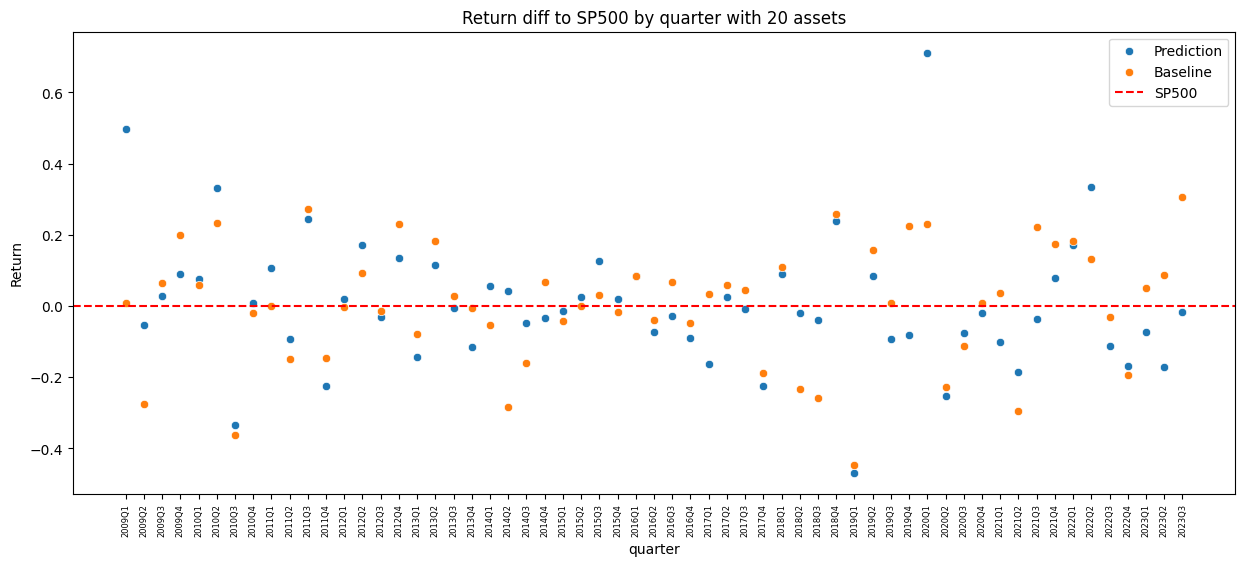

In [99]:
plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_returns_quarters, x='quarter', y='prediction_return',label='Prediction')
sns.scatterplot(data=df_returns_quarters, x='quarter', y='baseline_return',label='Baseline')
plt.axhline(y=0.0, color='r', linestyle='--', label='SP500')
plt.title(f'Return diff to SP500 by quarter with {n_assets} assets')
plt.ylabel('Return')
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.show()

### Comparing predictions versus the return of the market for each sector

For each quarter, and sector, we will calculate the return of the model for the top 20 assets compared to the return of the sector

In [100]:
n_assets = 20
sector_returns = calculate_returns(sector_df=True,n_assets=n_assets,column='asset_return_diff_sp500')

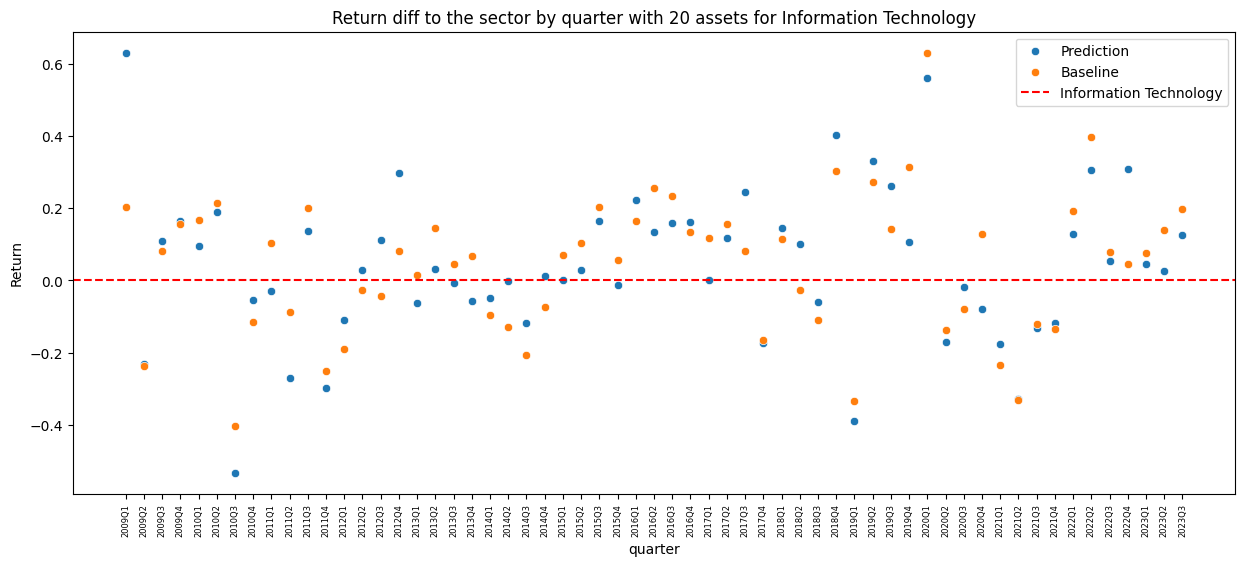

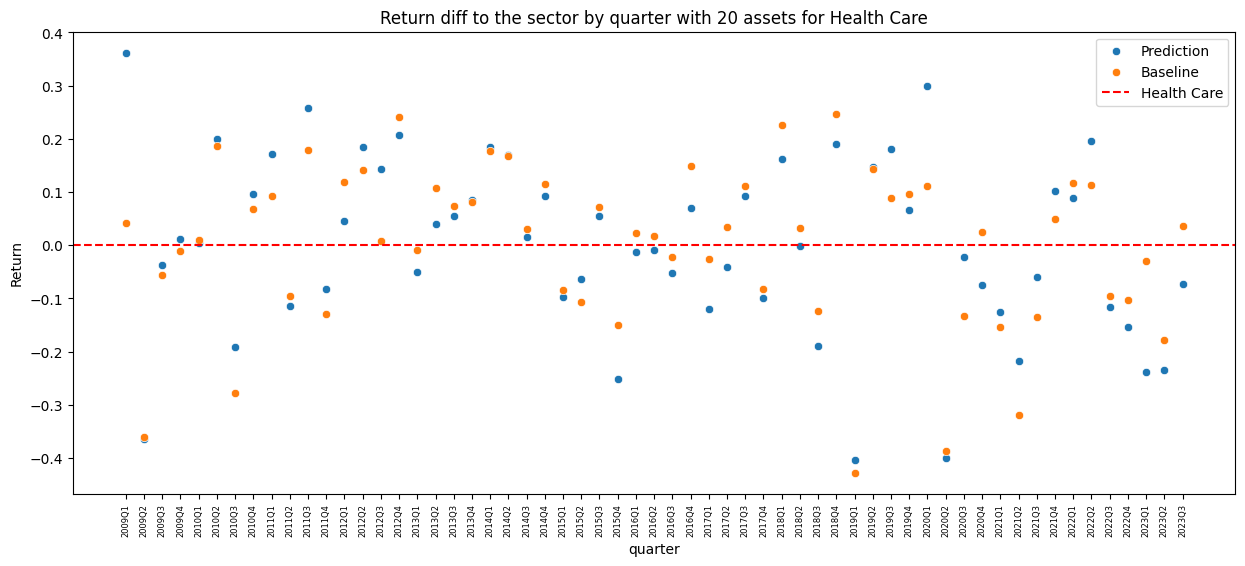

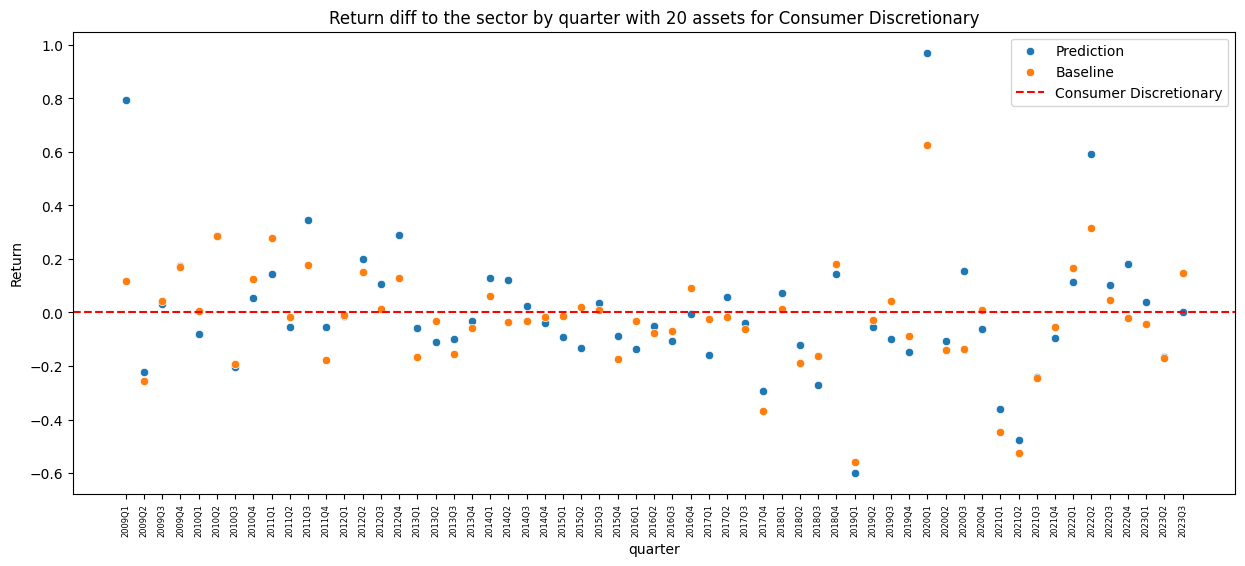

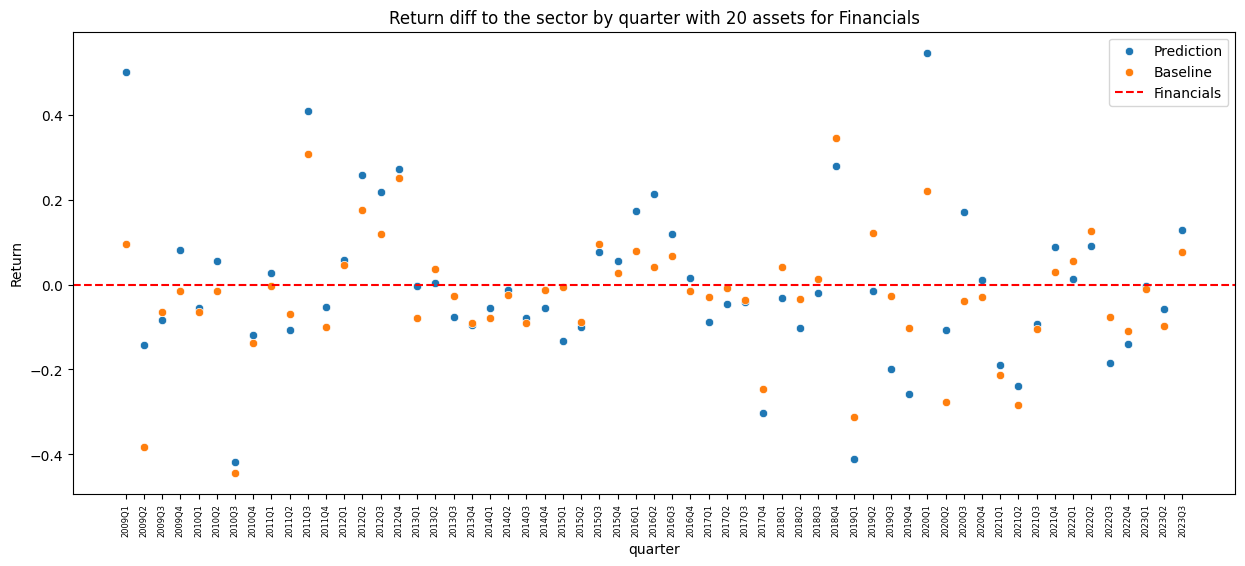

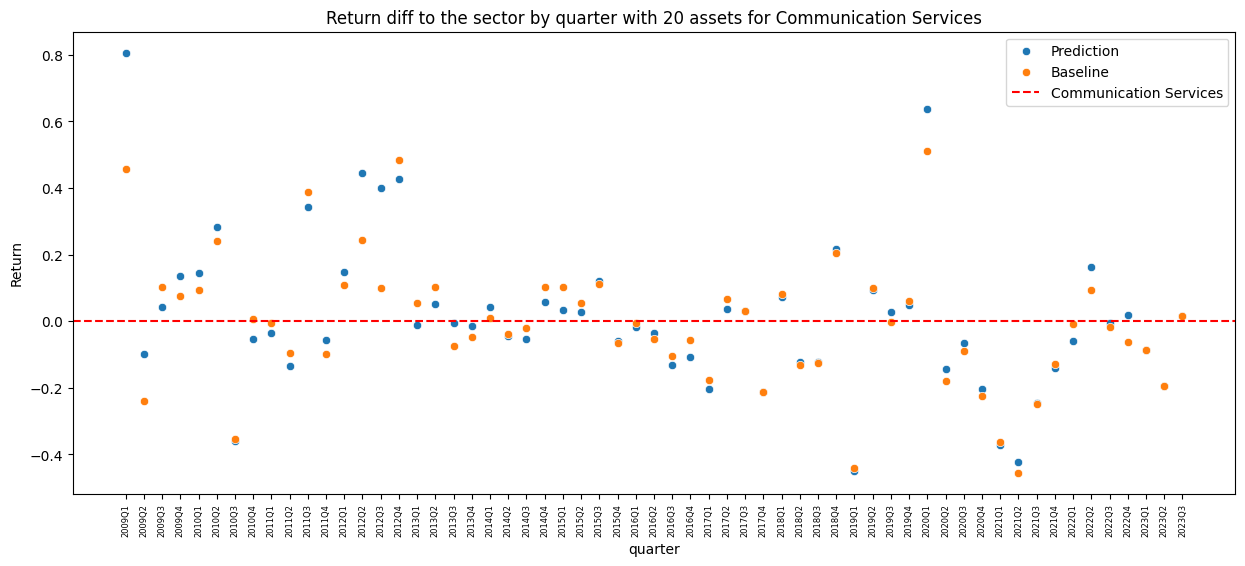

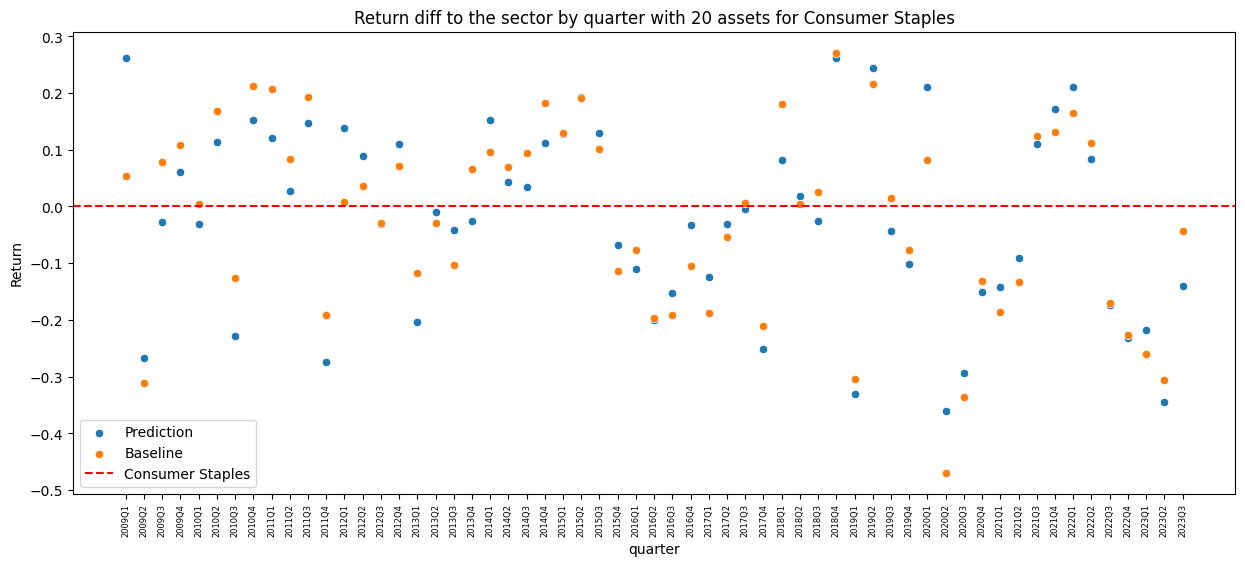

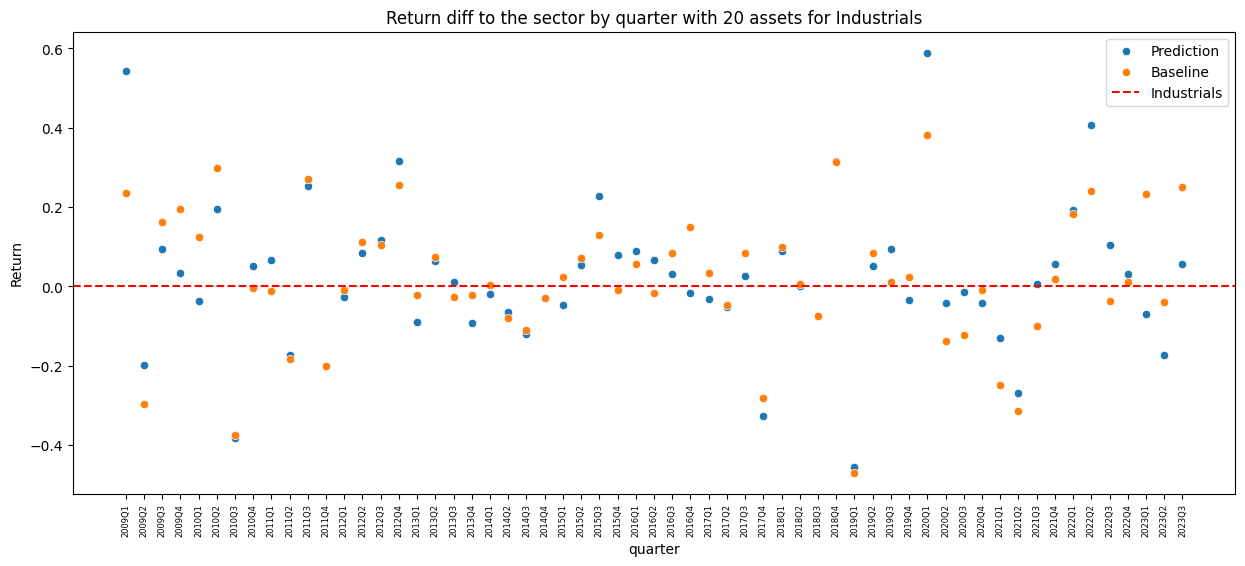

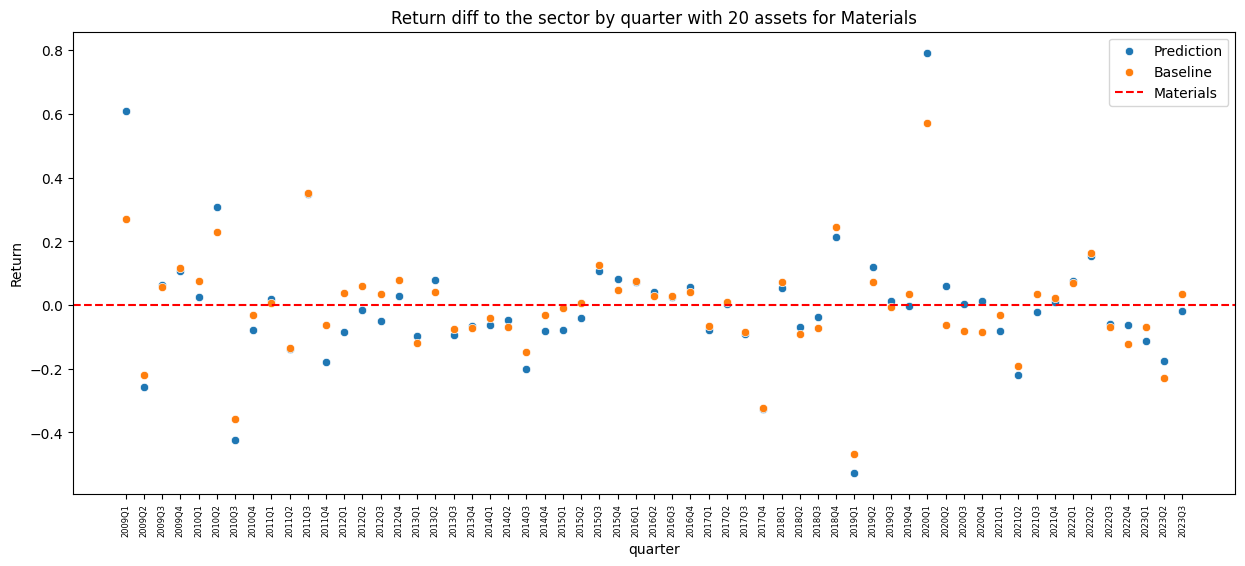

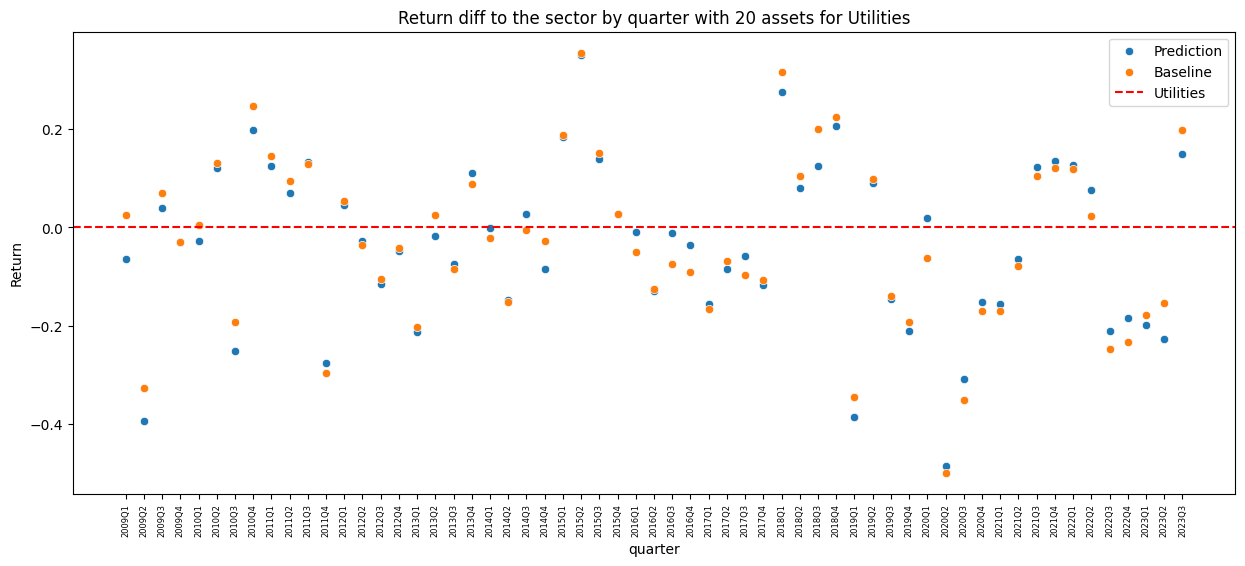

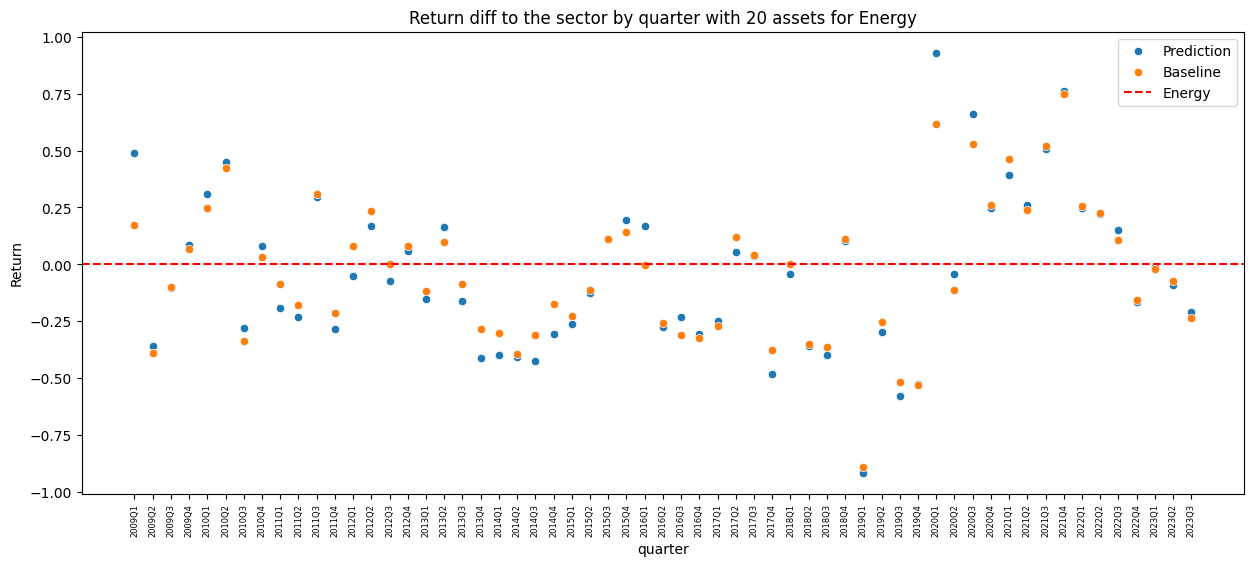

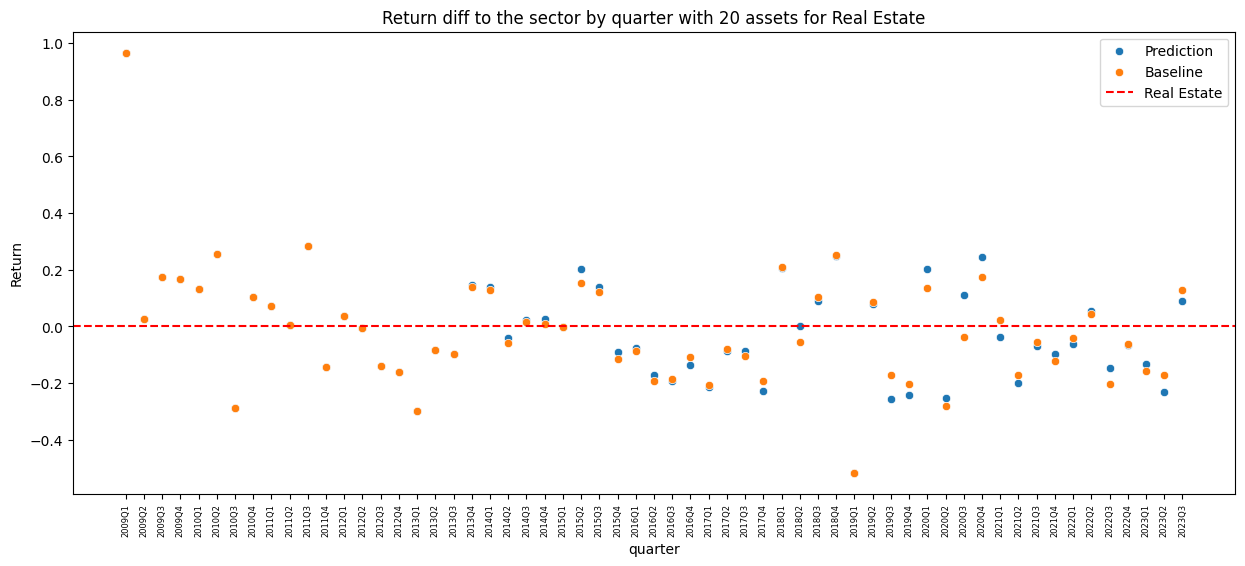

In [101]:
for sector in sector_returns['sector'].unique():
    df_sector = sector_returns[sector_returns['sector'] == sector]
    plt.subplots(figsize=(15, 6))
    sns.scatterplot(data=df_sector, x='quarter', y='prediction_return',label='Prediction')
    sns.scatterplot(data=df_sector, x='quarter', y='baseline_return',label='Baseline')
    plt.axhline(y=0.0, color='r', linestyle='--', label=sector)
    plt.title(f'Return diff to the sector by quarter with {n_assets} assets for {sector}')
    plt.ylabel('Return')
    plt.xticks(rotation=90, fontsize=6)
    plt.legend()
    plt.show()

In [102]:
n_assets = 20
sp500['date'] = sp500['date'].astype(str)
df_returns_quarters = calculate_returns(n_assets=n_assets,
                                        column='1year_price_variation').merge(sp500,
                                                                              left_on='quarter', 
                                                                              right_on='date', how='left').drop(columns='date')


In [103]:
acumulative_year = acumulative_year_earnings(df_returns_quarters)

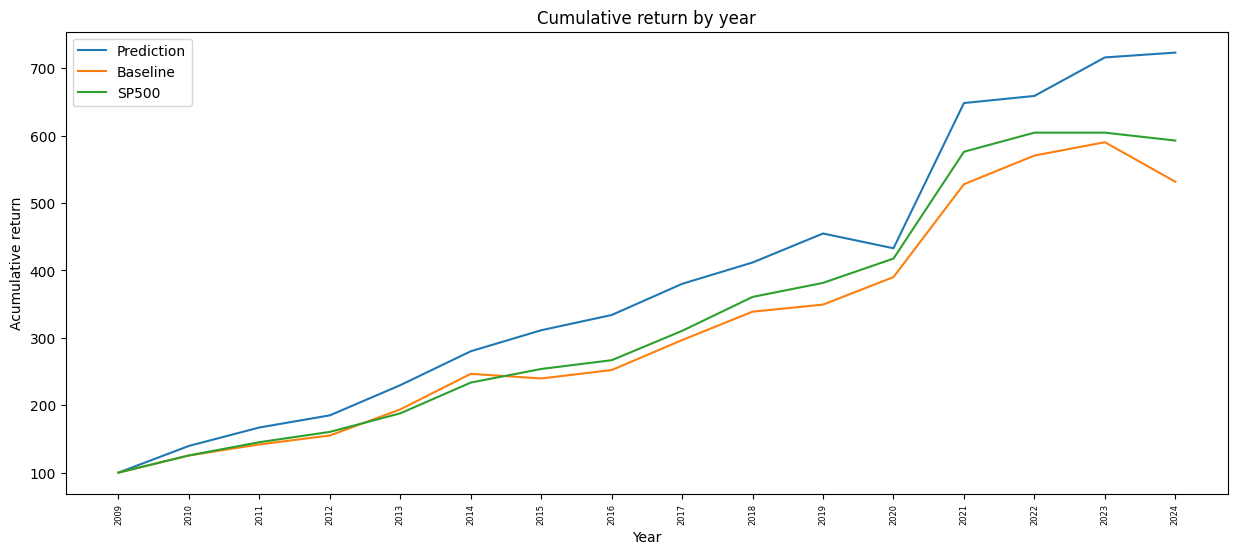

In [104]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_prediction_return',label='Prediction')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_baseline_return',label='Baseline')
sns.lineplot(data=acumulative_year, x=acumulative_year.index, y='cumulative_return_1year_sp500_return',label='SP500')
plt.title('Cumulative return by year')
plt.xticks(rotation=90, fontsize=6)
plt.xlabel('Year')
plt.ylabel('Acumulative return')
plt.show()

In [105]:
acumulative_year.iloc[-1]

cumulative_return_prediction_return     723.138573
cumulative_return_baseline_return       531.605529
cumulative_return_1year_sp500_return    592.642963
Name: 2024, dtype: float64

In [106]:
### CAGR
cagr = lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / len(x)) - 1
cagr(acumulative_year)*100

cumulative_return_prediction_return     13.162190
cumulative_return_baseline_return       11.006739
cumulative_return_1year_sp500_return    11.763391
dtype: float64

In [107]:
(acumulative_year['cumulative_return_prediction_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.9375

In [108]:
(acumulative_year['cumulative_return_baseline_return'] > acumulative_year['cumulative_return_1year_sp500_return']).mean()

0.125

In [109]:
n_assets = 5
sector_returns = calculate_returns(sector_df=True,n_assets=n_assets,column='1year_price_variation')

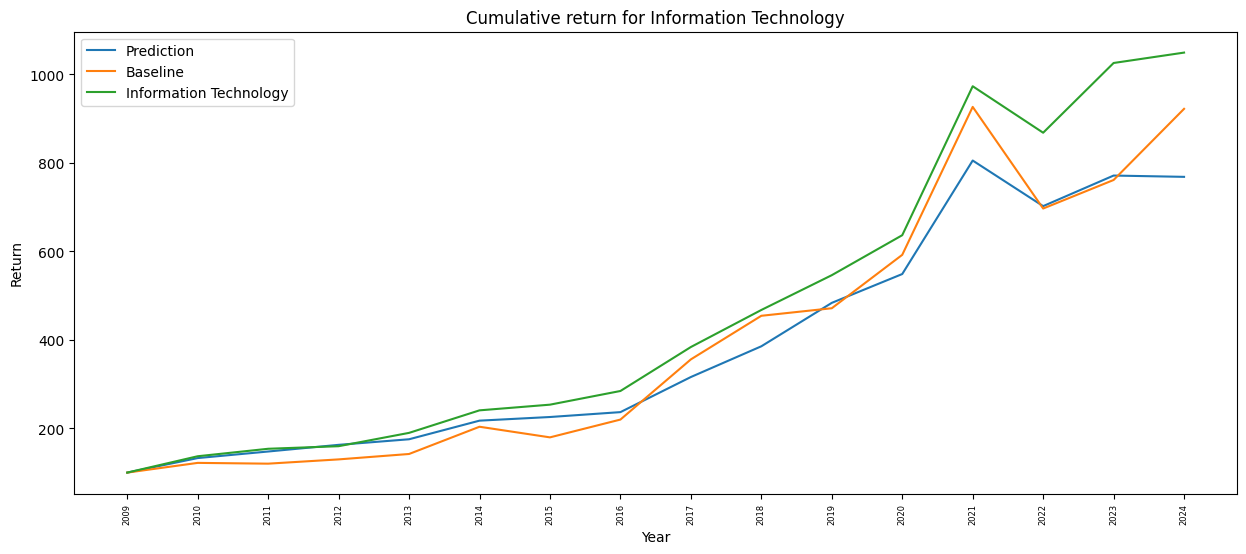

Anualized return for Information Technology
cumulative_return_prediction_return    13.592283
cumulative_return_baseline_return      14.894145
cumulative_return_sector_return        15.825332
dtype: float64


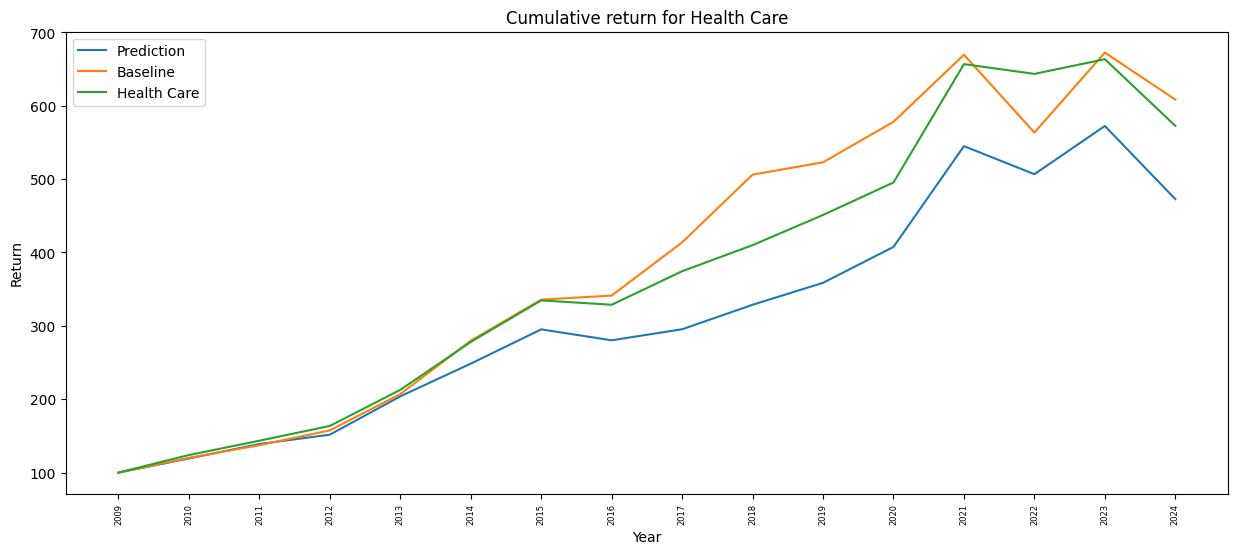

Anualized return for Health Care
cumulative_return_prediction_return    10.196098
cumulative_return_baseline_return      11.946829
cumulative_return_sector_return        11.523774
dtype: float64


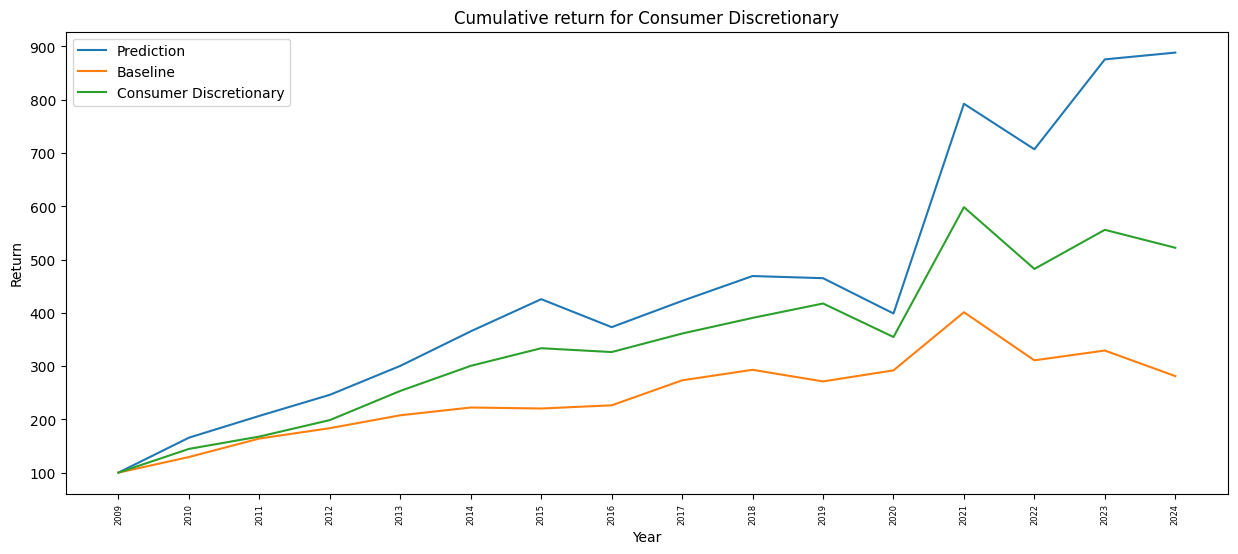

Anualized return for Consumer Discretionary
cumulative_return_prediction_return    14.628377
cumulative_return_baseline_return       6.674209
cumulative_return_sector_return        10.881734
dtype: float64


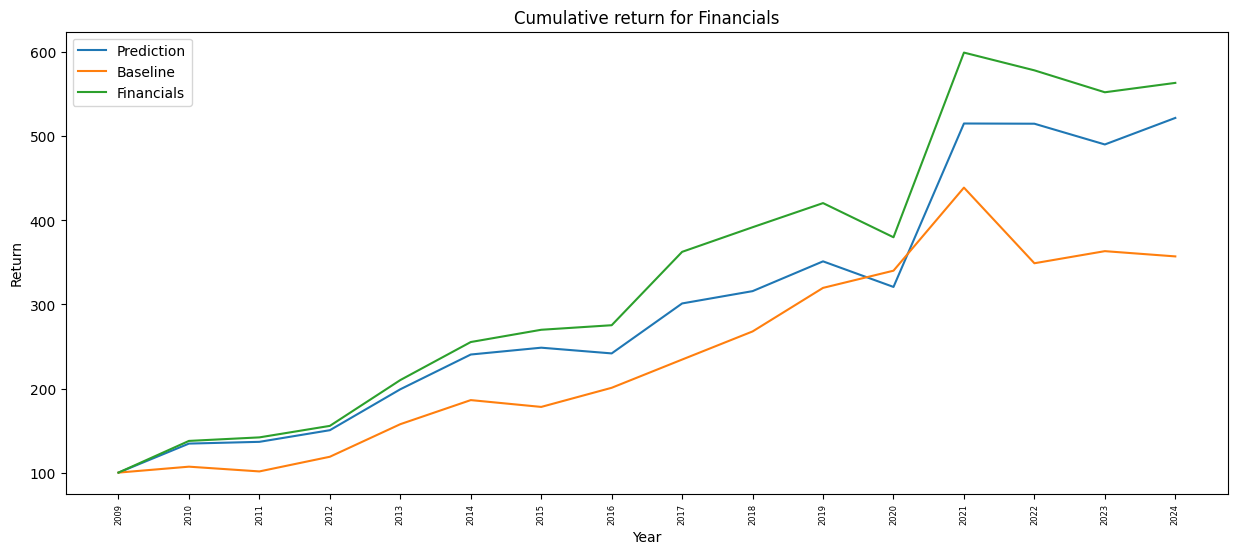

Anualized return for Financials
cumulative_return_prediction_return    10.877408
cumulative_return_baseline_return       8.280418
cumulative_return_sector_return        11.411276
dtype: float64


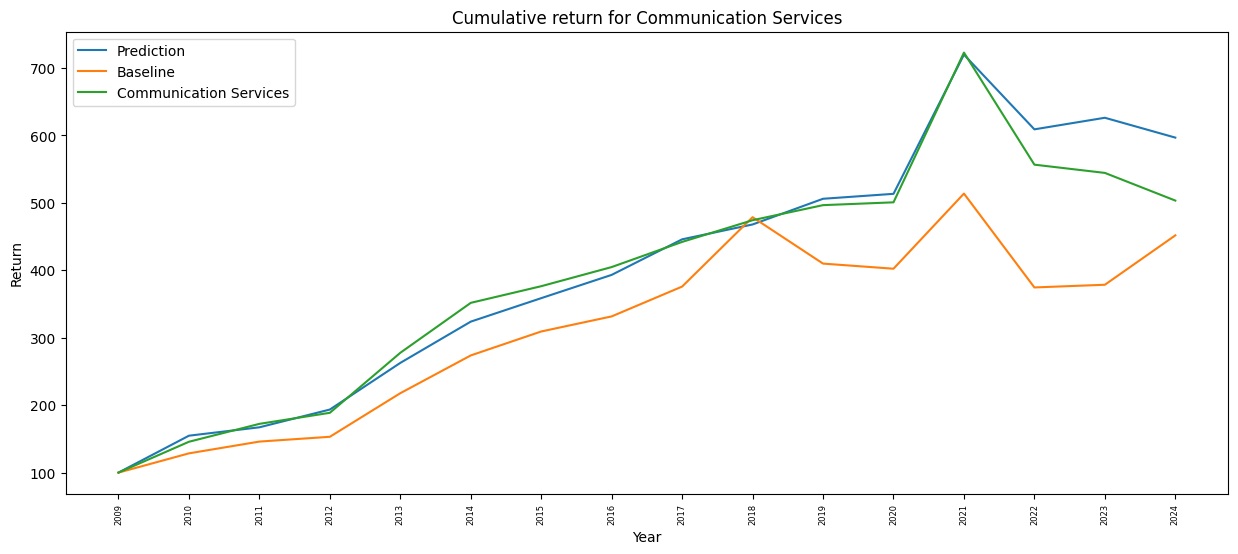

Anualized return for Communication Services
cumulative_return_prediction_return    11.809543
cumulative_return_baseline_return       9.881442
cumulative_return_sector_return        10.626767
dtype: float64


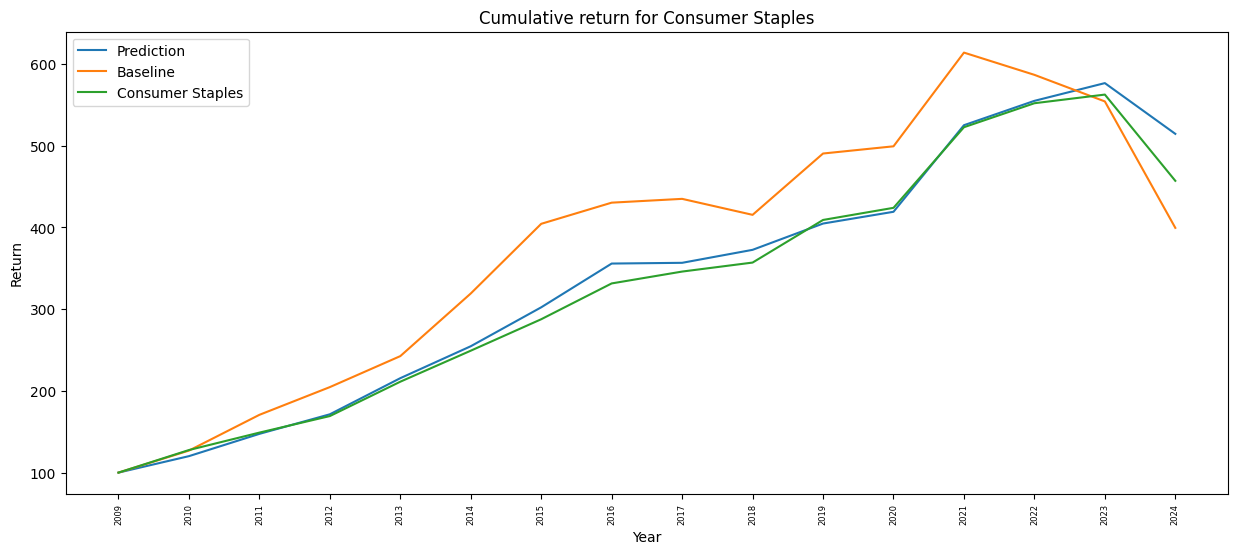

Anualized return for Consumer Staples
cumulative_return_prediction_return    10.780033
cumulative_return_baseline_return       9.041555
cumulative_return_sector_return         9.962847
dtype: float64


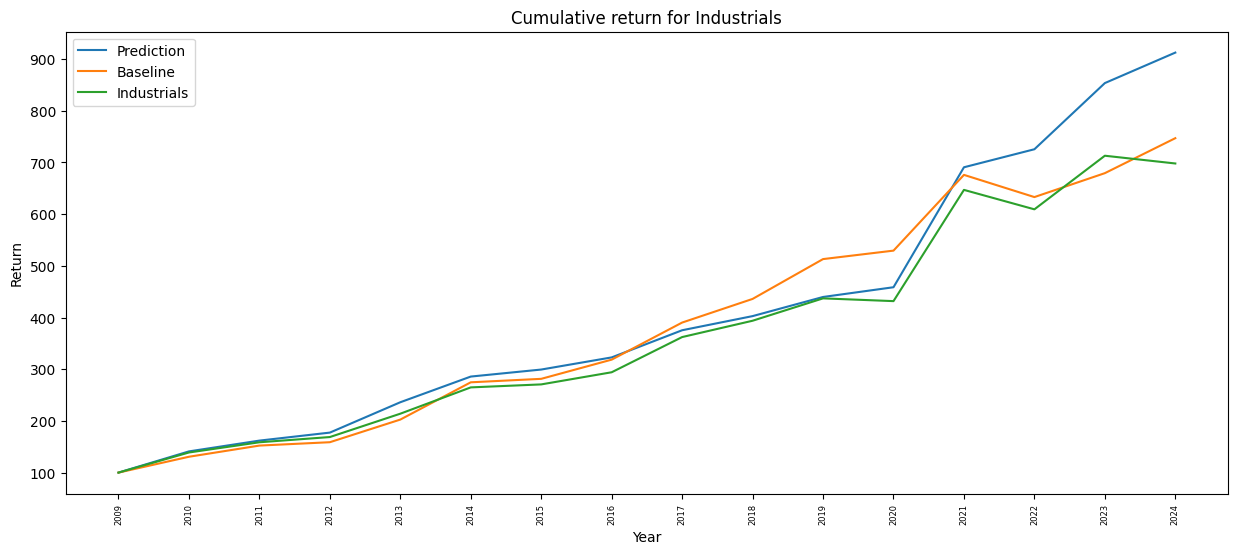

Anualized return for Industrials
cumulative_return_prediction_return    14.819392
cumulative_return_baseline_return      13.391614
cumulative_return_sector_return        12.912353
dtype: float64


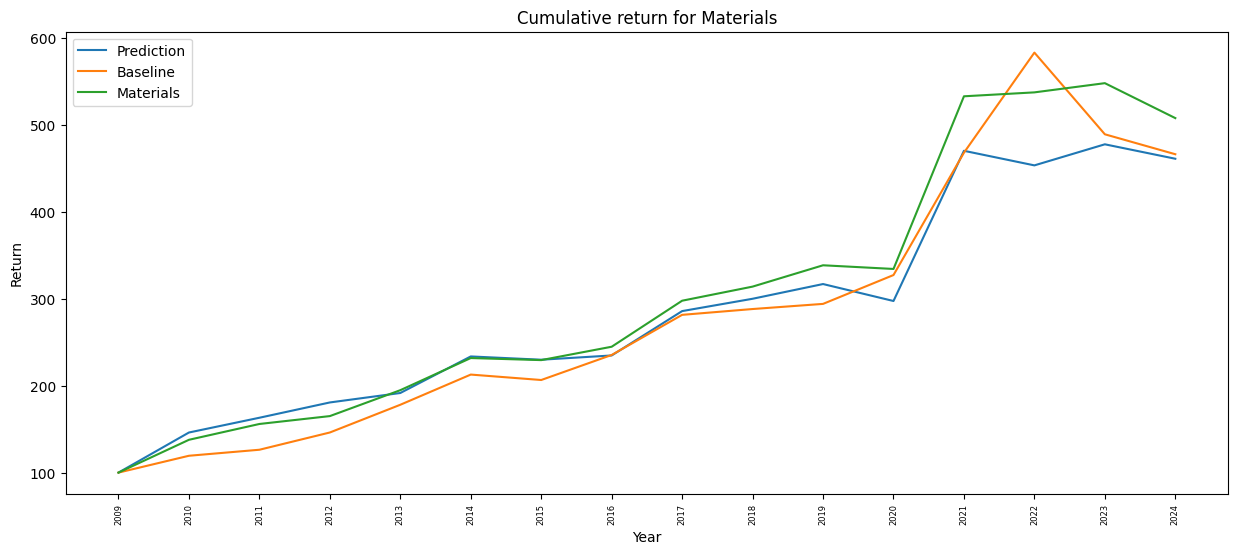

Anualized return for Materials
cumulative_return_prediction_return    10.025168
cumulative_return_baseline_return      10.102104
cumulative_return_sector_return        10.691435
dtype: float64


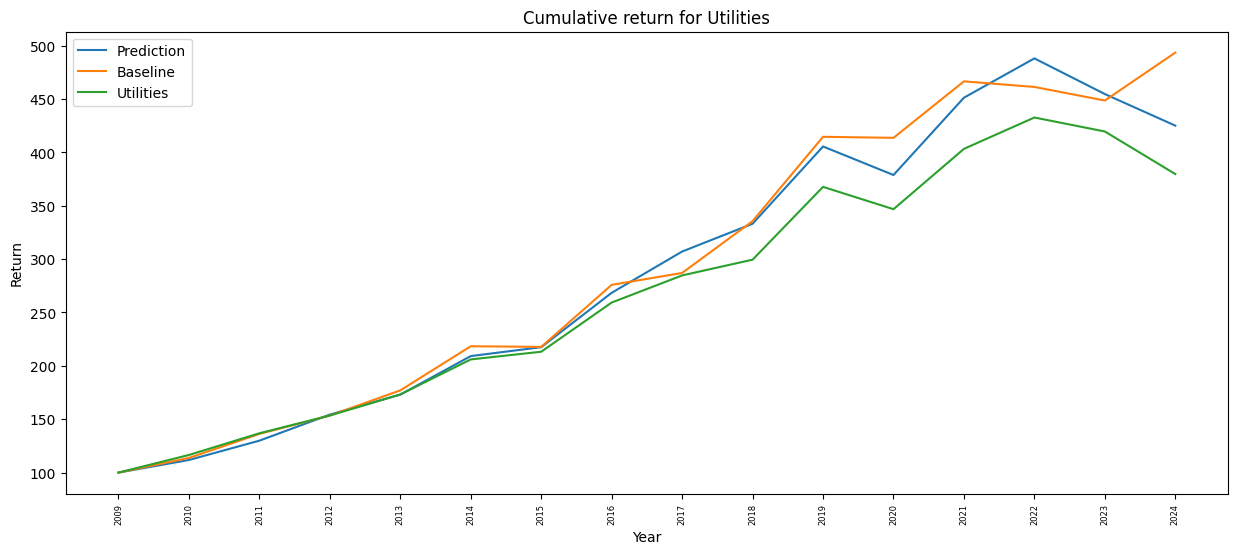

Anualized return for Utilities
cumulative_return_prediction_return     9.465220
cumulative_return_baseline_return      10.491151
cumulative_return_sector_return         8.695793
dtype: float64


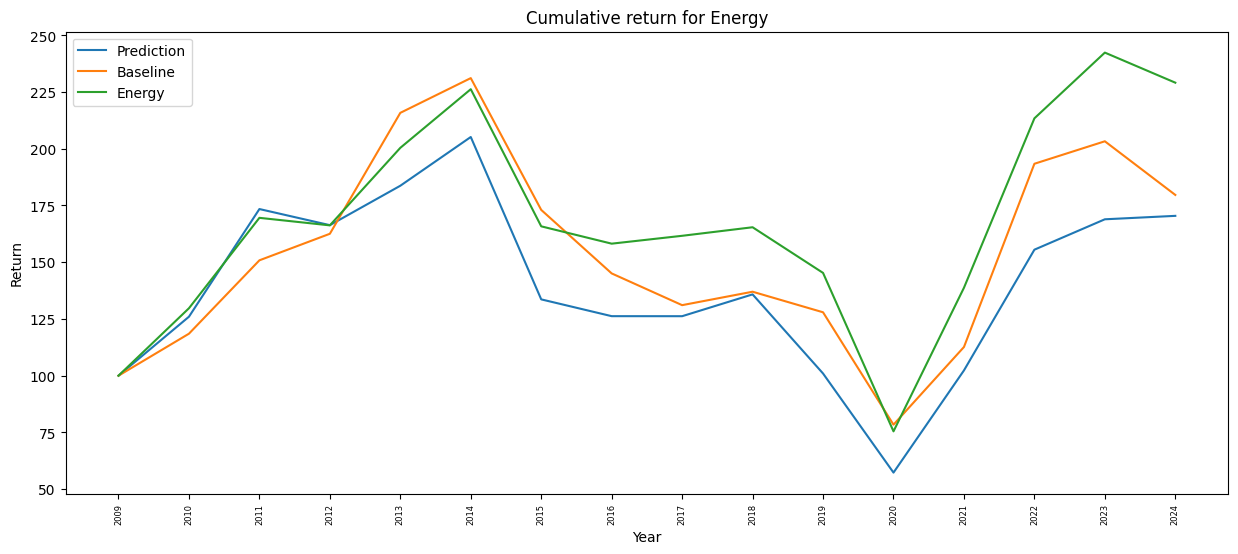

Anualized return for Energy
cumulative_return_prediction_return    3.388525
cumulative_return_baseline_return      3.729504
cumulative_return_sector_return        5.318426
dtype: float64


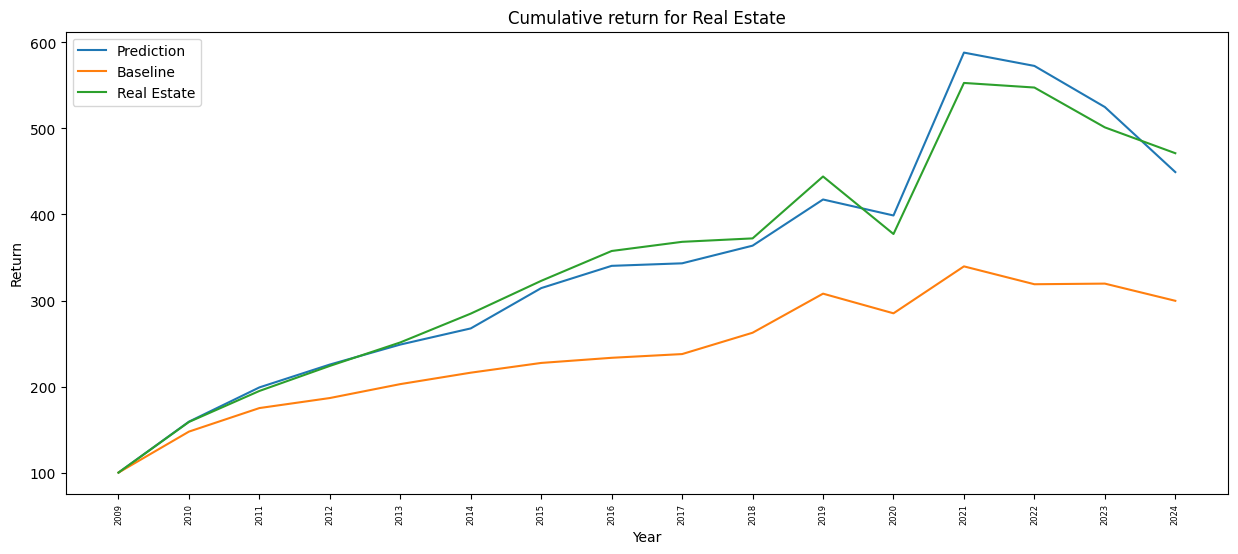

Anualized return for Real Estate
cumulative_return_prediction_return     9.845480
cumulative_return_baseline_return       7.100299
cumulative_return_sector_return        10.173296
dtype: float64


In [110]:
for sector in sector_returns['sector'].unique():
    sector_acumulative_year = acumulative_year_earnings(sector_returns[sector_returns['sector'].str.contains(sector)])
    plt.subplots(figsize=(15, 6))
    sns.lineplot(data=sector_acumulative_year, x=sector_acumulative_year.index, y='cumulative_return_prediction_return',label='Prediction')
    sns.lineplot(data=sector_acumulative_year, x=sector_acumulative_year.index, y='cumulative_return_baseline_return',label='Baseline')
    sns.lineplot(data=sector_acumulative_year, x=sector_acumulative_year.index, y='cumulative_return_sector_return',label=sector)
    plt.title(f'Cumulative return for {sector}')
    plt.xticks(rotation=90, fontsize=6)
    plt.xlabel('Year')
    plt.ylabel('Return')
    plt.show()
    
    print(f"Anualized return for {sector}")
    print(cagr(sector_acumulative_year)*100)

In [111]:
# comprobacion de que no hay 20 empresas de real estate en gran parte del tiempo, por eso salen los mismos valores
df_final[df_final['new_sector']=='Real Estate'].groupby('quarter')['asset_num'].count()

quarter
2006Q1     9
2006Q2    11
2006Q3    11
2006Q4    12
2007Q1    14
          ..
2022Q3    32
2022Q4    32
2023Q1    31
2023Q2    31
2023Q3    31
Name: asset_num, Length: 71, dtype: int64

### Comparing the proportion of the percentage of the sectors invested in the portfolio

In [112]:
# caso hecho para 20 empresas
df_sectors = pd.DataFrame(columns=['quarter','percentage']) 
for i in range(len(datasets)):
    quarter = unique_quarters[i+window_size] 
    df = create_results_df(df_final,predictions_list, quarter,True,'1year_price_variation')
    sectors_invested = df.sort_values('rank_pos', ascending=False).head(20)['new_sector'].value_counts(normalize=True)
    data = {'quarter':quarter,'percentage':sectors_invested}
    df_pivot = pd.DataFrame(data).reset_index()
    df_sectors = pd.concat([df_sectors,df_pivot])
df_sectors['año'] = df_sectors['quarter'].str[:4]
df_sectors = df_sectors.groupby(['año','new_sector'])['percentage'].mean().reset_index()

C:\Users\ALEX\AppData\Local\Temp\ipykernel_5360\4067623807.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sectors = pd.concat([df_sectors,df_pivot])
C:\Users\ALEX\AppData\Local\Temp\ipykernel_5360\4067623807.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sectors = df_sectors.groupby(['año','new_sector'])['percentage'].mean().reset_index()


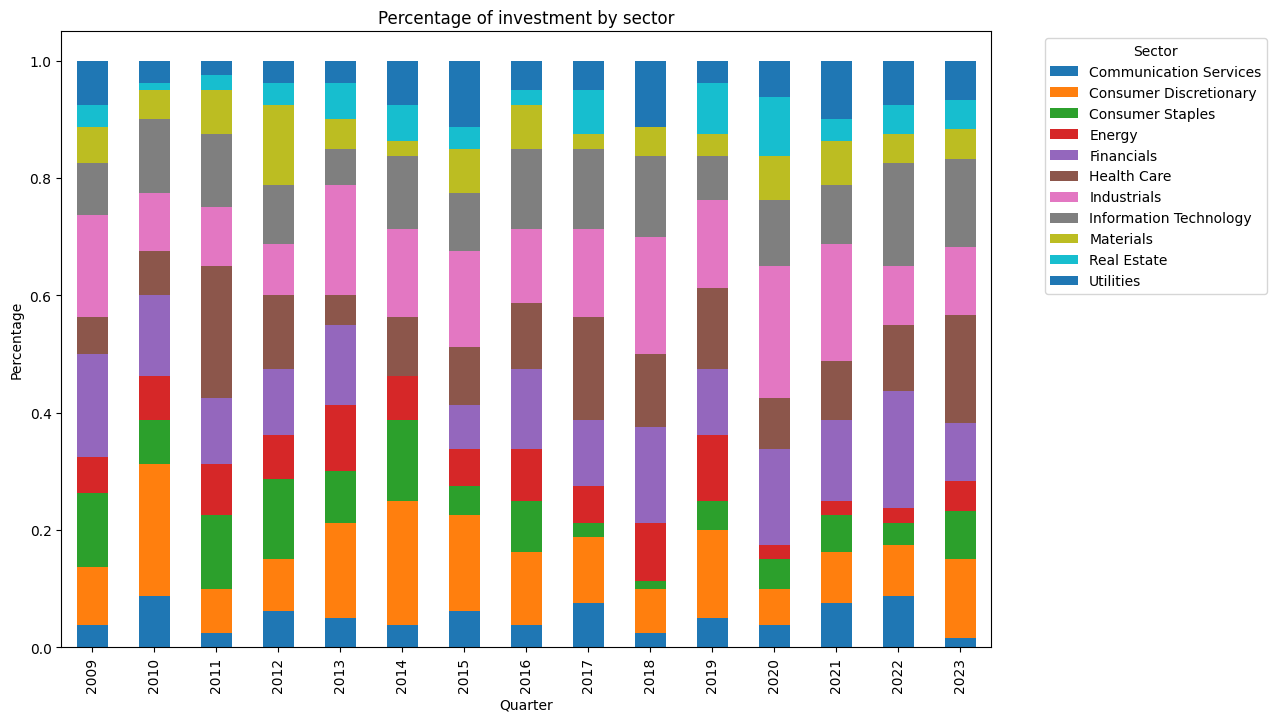

In [113]:
df_sectors.pivot(index='año',columns='new_sector',values='percentage').plot(
        kind="bar",
        stacked=True,
        figsize=(12, 8),)
plt.legend(title="Sector",bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Percentage of investment by sector")
plt.xlabel("Quarter")
plt.ylabel("Percentage")
plt.show()